In [10]:
import numpy as np
import pandas as pd

# Feature Scaling
from sklearn.preprocessing import RobustScaler

# Visaulization
import matplotlib.pyplot as plt
import seaborn as sns

# Classifier (machine learning algorithm)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import cross_val_score, cross_val_predict

# Parameter Tuning
from sklearn.model_selection import GridSearchCV

# Settings
pd.options.mode.chained_assignment = None # Stop warning when use inplace=True of fillna

In [11]:
train_set =  pd.read_csv('train.csv')
test_set =  pd.read_csv('test.csv')

In [12]:
def cont_plot(df, feature_name, target_name, palettemap, hue_order, feature_scale):
    df['Counts'] = "" # A trick to skip using an axis (either x or y) on splitting violinplot
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    sns.distplot(df[feature_name], ax=axis0);
    sns.violinplot(x=feature_name, y="Counts", hue=target_name, hue_order=hue_order, data=df,
                   palette=palettemap, split=True, orient='h', ax=axis1)
    axis1.set_xticks(feature_scale)
    plt.show()
    # WARNING: This will leave Counts column in dataset if you continues to use this dataset

# Categorical/Ordinal Data Plot
def cat_plot(df, feature_name, target_name, palettemap):
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    df[feature_name].value_counts().plot.pie(autopct='%1.1f%%',ax=axis0)
    sns.countplot(x=feature_name, hue=target_name, data=df,
                  palette=palettemap,ax=axis1)
    plt.show()


survival_palette = {0: "black", 1: "orange"} # Color map for visualization

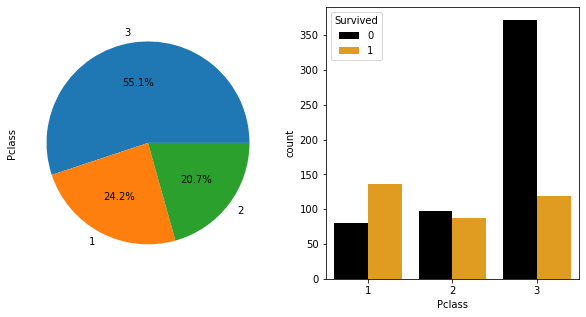

In [13]:
cat_plot(train_set, 'Pclass','Survived', survival_palette)

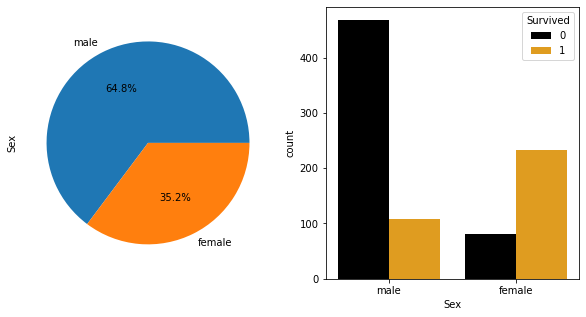

In [14]:
cat_plot(train_set, 'Sex','Survived', survival_palette)

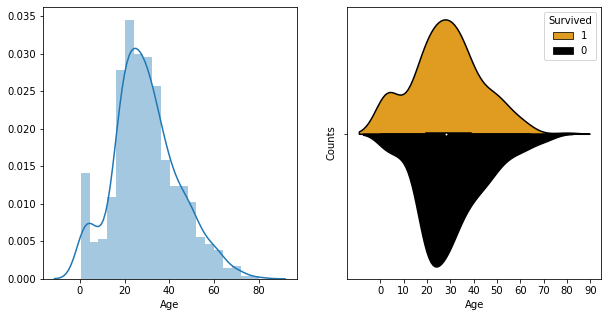

In [15]:
age_set_nonan = train_set[['Age','Survived']].copy().dropna(axis=0)
cont_plot(age_set_nonan, 'Age', 'Survived', survival_palette, [1, 0], range(0,100,10))

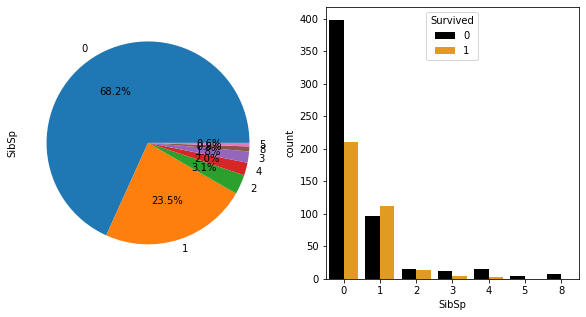

In [16]:
cat_plot(train_set, 'SibSp', 'Survived', survival_palette)

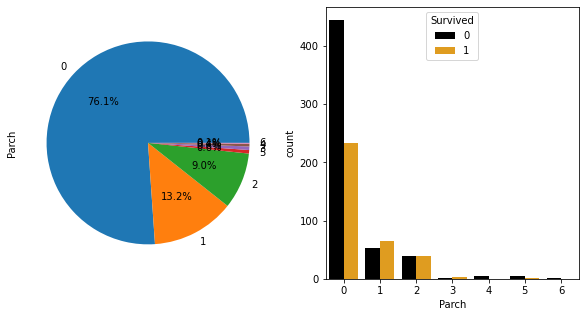

In [17]:
cat_plot(train_set, 'Parch', 'Survived', survival_palette)

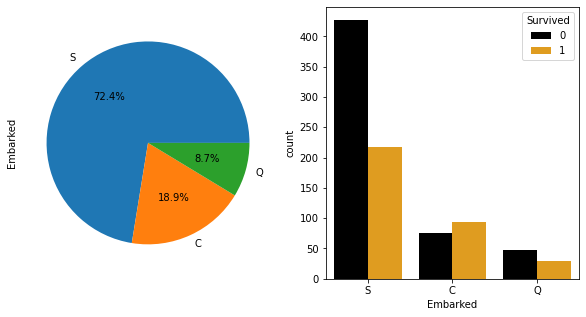

In [18]:
emb_set_nonan = train_set[['Embarked','Survived']].copy().dropna(axis=0)
cat_plot(train_set, 'Embarked','Survived', survival_palette)

In [19]:
combined_set = [train_set, test_set] # combined 2 datasets for more efficient processing

for dataset in combined_set:
    dataset["Age"].fillna(dataset["Age"].median(), inplace=True)
    dataset["Fare"].fillna(dataset["Fare"].median(), inplace=True)

train_set["Embarked"].fillna(train_set["Embarked"].value_counts().index[0], inplace=True)
age_bins = [0,15,35,45,60,200]
age_labels = ['15-','15-35','35-45','40-60','60+']
fare_bins = [0,10,30,60,999999]
fare_labels = ['10-','10-30','30-60','60+']

def get_title(dataset, feature_name):
    return dataset[feature_name].map(lambda name:name.split(',')[1].split('.')[0].strip())

for dataset in combined_set:
    dataset['AgeRange'] = pd.cut(dataset['Age'], bins=age_bins, labels=age_labels, include_lowest=True)
    dataset['FareRange'] = pd.cut(dataset['Fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)
    dataset['FamilySize'] = dataset['SibSp'] + train_set['Parch']
    dataset['HasCabin'] = dataset['Cabin'].notnull().astype(int) # NaN Cabins will become 0, otherwise 1
    dataset['Title'] = get_title(dataset, 'Name')

In [20]:
for dataset in combined_set:
    dataset['Family'] = ''
    dataset.loc[dataset['FamilySize'] == 0, 'Family'] = 'alone'
    dataset.loc[(dataset['FamilySize'] > 0) & (dataset['FamilySize'] <= 3), 'Family'] = 'small'
    dataset.loc[(dataset['FamilySize'] > 3) & (dataset['FamilySize'] <= 6), 'Family'] = 'medium'
    dataset.loc[dataset['FamilySize'] > 6, 'Family'] = 'large'

In [21]:
title_dict = {
                "Mr" :        "Mr",
                "Miss" :      "Miss",
                "Mrs" :       "Mrs",
                "Master" :    "Master",
                "Dr":         "Scholar",
                "Rev":        "Religious",
                "Col":        "Officer",
                "Major":      "Officer",
                "Mlle":       "Miss",
                "Don":        "Noble",
                "the Countess":"Noble",
                "Ms":         "Mrs",
                "Mme":        "Mrs",
                "Capt":       "Noble",
                "Lady" :      "Noble",
                "Sir" :       "Noble",
                "Jonkheer":   "Noble"
            }

for dataset in combined_set:
    dataset['TitleGroup'] = dataset.Title.map(title_dict)
test_set.at[414, 'TitleGroup'] = 'Noble'
X_train = train_set.drop(['Survived','PassengerId','Name','Age','Fare','Ticket','Cabin','SibSp','Parch','Title','FamilySize'], axis=1)
X_test = test_set.drop(['PassengerId','Name','Age','Fare','Ticket','Cabin','SibSp','Parch','Title','FamilySize'], axis=1)

y_train = train_set['Survived']  # Relocate Survived target feature to y_train

In [22]:
X_train = train_set.drop(['Survived','PassengerId','Name','Age','Fare','Ticket','Cabin','SibSp','Parch','Title','FamilySize'], axis=1)
X_test = test_set.drop(['PassengerId','Name','Age','Fare','Ticket','Cabin','SibSp','Parch','Title','FamilySize'], axis=1)

y_train = train_set['Survived']  # Relocate Survived target feature to y_train

In [23]:
X_train_analysis = X_train.copy()
X_train_analysis['Sex'] = X_train_analysis['Sex'].map({'male': 0, 'female': 1}).astype(int)
X_train_analysis['Embarked'] = X_train_analysis['Embarked'].map({'C': 0, 'Q': 1, 'S': 2}).astype(int)
X_train_analysis['Family'] = X_train_analysis['Family'].map({'alone': 0, 'small': 1, 'medium': 2, 'large': 3}).astype(int)

agerange_dict = dict(zip(age_labels, list(range(len(age_labels)))))
X_train_analysis['AgeRange'] = X_train_analysis['AgeRange'].map(agerange_dict).astype(int)

farerange_dict = dict(zip(fare_labels, list(range(len(fare_labels)))))
X_train_analysis['FareRange'] = X_train_analysis['FareRange'].map(farerange_dict).astype(int)

titlegroup_labels = list(set(title_dict.values()))
titlegroup_dict = dict(zip(titlegroup_labels, list(range(len(titlegroup_labels)))))
X_train_analysis['TitleGroup'] = X_train_analysis['TitleGroup'].map(titlegroup_dict).astype(int)

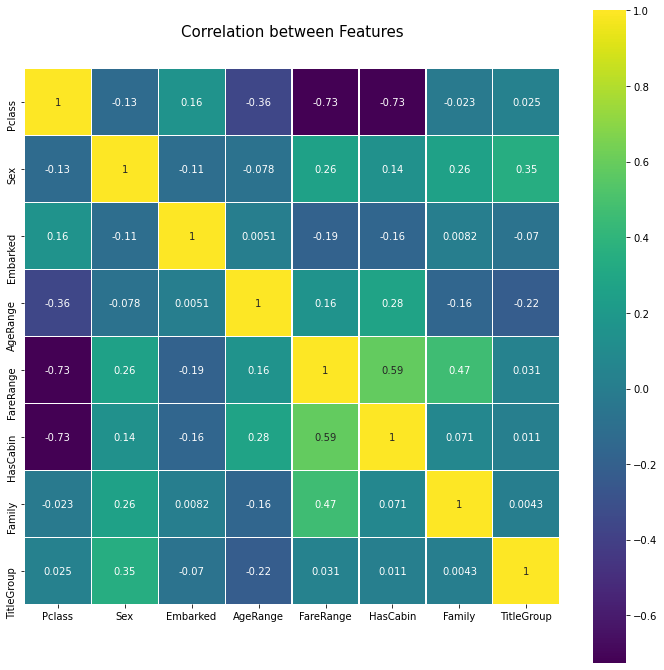

In [24]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlation between Features', y=1.05, size = 15)
sns.heatmap(X_train_analysis.corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True)

In [25]:
rforest_checker = RandomForestClassifier(random_state = 0)
rforest_checker.fit(X_train_analysis, y_train)
importances_df = pd.DataFrame(rforest_checker.feature_importances_, columns=['Feature_Importance'],
                              index=X_train_analysis.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
print(importances_df)

            Feature_Importance
Sex                   0.246173
TitleGroup            0.202074
Pclass                0.118036
AgeRange              0.107400
FareRange             0.103336
Family                0.100158
HasCabin              0.065008
Embarked              0.057816
